# Propensity Score Exercise Solution

In [1]:
import pandas as pd
import yaml
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split

import random

random.seed(1234)

First we read the dataset and calculate the proportion of deaths in each group

In [2]:
rhc = pd.read_csv('rhc_dataset.csv')
with open('confounders.yml', 'r') as f:
    confounders = yaml.safe_load(f)

rhc['swang1'] = (rhc['swang1'] == 'RHC').astype(int)
rhc['death'] = (rhc['death'] == 'Yes').astype(int)
rhc.groupby('swang1')['death'].mean()

swang1
0    0.629682
1    0.680403
Name: death, dtype: float64

# Auxiliary functions

In [3]:
def plot_results(ps_values, swang1, name=""):
    auc = round(roc_auc_score(swang1, ps_values), 4)
    sns.kdeplot(x=ps_values, hue=swang1, fill=True, common_norm=False, alpha=0.4).set_title(f"AUC {name}:{auc}")
    plt.show()

In [4]:
def train_model(X, y):
    parameters = {
        "learning_rate": [0.005, 0.01, 0.15, 0.2],
        "max_depth":[1, 2, 3, 4, 5],
        "n_estimators": [100, 150, 200, 300]
        }

#    parameters = {
#        "learning_rate": [0.001, 0.01, 0.2],
#        "max_depth":[1, 2, 3],
#        "n_estimators": [100, 200, 300]
#        }

    grid_cv = GridSearchCV(
        GradientBoostingClassifier(), 
        parameters, 
        scoring = "roc_auc",
        cv=5, n_jobs=-1)
    grid_cv.fit(X, y)
    return(grid_cv)

# 1. [Propensity scores first attempt]

Train a model for the Propensity Score (PS) with the treatment variable swang1.

In [5]:
# Transoforming categorical variables shouls be done inside the cross validation, and not before, because otherwise there can be some data leakage. In this exercise we did it directly for simplicity.

X = rhc[confounders ]
X = pd.get_dummies(X)
y = rhc['swang1']

In [6]:
ps_model = train_model(X, y)

In [7]:
print('Best Params')
print(ps_model.best_params_)

print('Best AUC')
print(ps_model.best_score_)

Best Params
{'learning_rate': 0.15, 'max_depth': 2, 'n_estimators': 300}
Best AUC
0.806015324308575


*QUESTION*: As you can see, the AUC obtained with boosting is similar to the one obtained with logistic regression. So, why using boosting instead of logistic regression?

We know they have similar AUC a posteriory. In general boosting can fit better to the data (because it provides nonlinear functions). So, if we only use logistic regression, we will not know whether we could have done better fitting using a more complex model.



# 2. [Overfitting]

Use the trained model to make predictions (probabilities) on the same dataset and calculate its AUC. Verify that the AUC with respect to the predicted probabilities is higher than the AUC reported from the cross validation.

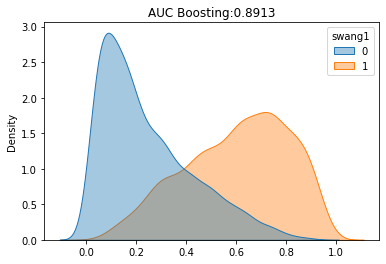

In [8]:
ps_values = ps_model.predict_proba(X)[:, 1]

plot_results(ps_values, y, name="Boosting")

Notice that the AUC calculated with the predictions is quite higher than the reported by the cross validation. The latter is a more reliable metric than the former, so we are overfitting our dataset!

*NOTE*: You can try the same process with logistic regression. In that case you will see that, logistic regression overfits less or none at all. So, depending on the model you use, even you use cross validation, you will overfit more or less.

# 3. [Propensity scores with cross-fitting]

Calculate the PS using 2-fold cross-fitting: split the data set into 2 equally sized data sets $D_1$ and $D_2$. Train a model for PS using $D_1$ and predict on $D_2$, and vice versa. Calculate the AUC with the new propensity score.

In [9]:
D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=0.5, stratify = y)

In [10]:
ps_model_boost_1 = train_model(D1_X, D1_y)
ps_model_boost_2 = train_model(D2_X, D2_y)

# We predict on the dataset D1 using the model trained on D2 and vice versa
ps_1 = ps_model_boost_2.predict_proba(D1_X)[:, 1]
ps_2 = ps_model_boost_1.predict_proba(D2_X)[:, 1]

swang1 = pd.concat([D1_y, D2_y])
ps_values = np.concatenate([ps_1, ps_2])

In [11]:
print(roc_auc_score(swang1, ps_values))

0.7918057958187499


This is the obtained AUC with the propensity scores calculated with cross fitting, which is closer to the one obtained from the cross validation

# 4. [Visual Inspection]

Make the plot of the density of the PS by treatment group. Are the two groups comparable?

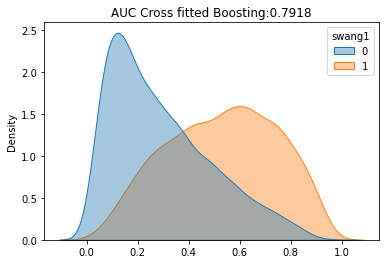

In [12]:
plot_results(ps_values, swang1, name="Cross fitted Boosting")

Since the support of both groups is the same, they are fully comparable.

# 5. [ATEs with T-learners and cross-fitting]

Calculate ATEs using T-learner & cross-fitting in order to estimate the effect of swang1 to death:

## Split the data set into 2 equally sized data sets D1 and D2

In [13]:
X = rhc[ ['swang1'] + confounders ]
X = pd.get_dummies(X)
y = rhc['death']

In [14]:
D1_X, D2_X, D1_y, D2_y = train_test_split(X, y, test_size=0.5, stratify = y)

## Take D1 and and train two models:

- With swang1 = RHC, called $f_{1,R}$
- With swang1 = Non-RHC, called $f_{1,N}$


In [15]:
data_1_rhc_X = D1_X[D1_X.swang1 == 1]
data_1_rhc_y = D1_y[D1_X.swang1 == 1]
ps_model_boost_1_rhc = train_model(data_1_rhc_X, data_1_rhc_y)

data_1_nrhc_X = D1_X[D1_X.swang1 == 0]
data_1_nrhc_y = D1_y[D1_X.swang1 == 0]
ps_model_boost_1_nrhc = train_model(data_1_nrhc_X, data_1_nrhc_y)

## Repeat the process with D2 and train two models

In [16]:
data_2_rhc_X = D2_X[D2_X.swang1 == 1]
data_2_rhc_y = D2_y[D2_X.swang1 == 1]
ps_model_boost_2_rhc = train_model(data_2_rhc_X, data_2_rhc_y)

data_2_nrhc_X = D2_X[D2_X.swang1 == 0]
data_2_nrhc_y = D2_y[D2_X.swang1 == 0]
ps_model_boost_2_nrhc = train_model(data_2_nrhc_X, data_2_nrhc_y)

## Calculate on D2 the vector of predictions $f_{1,R}(x)−f_{1,N}(x)$ where x ranges for all observations in D2.

Later, switch roles between D1 and D2 and calculate the ATE.

In [17]:
ATE_1 = ps_model_boost_2_rhc.predict_proba(D1_X)[:, 1]
ATE_1 = ATE_1 - ps_model_boost_2_nrhc.predict_proba(D1_X)[:, 1]

ATE_2 = ps_model_boost_1_rhc.predict_proba(D2_X)[:, 1]
ATE_2 = ATE_2 - ps_model_boost_1_nrhc.predict_proba(D2_X)[:, 1]

ATE_values = np.concatenate([ATE_1, ATE_1])

The ATE is

In [18]:
ATE_values.mean()

0.00615156616766784